In [1]:
import pints
import pints.toy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils

import numpy as np
import matplotlib.pyplot as plt
import GPy

import string
from itertools import product

## Specifying model

In [2]:
# Create a model
model = pints.toy.LogisticModel()

n_parameters = model.n_parameters()
n_outputs = model.n_outputs()
# real_parameters = np.array(model.suggested_parameters())
real_parameters = np.array([0.15, 500])

values, times, noise_stds = emutils.simulate(model,
                                             parameters=real_parameters
                                            )

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise_stds)

print("Number of parameters: ", n_parameters)
print("Parameter values: ", real_parameters)
print("Example problem values:\n", problem.values()[:5])

Number of parameters:  2
Parameter values:  [1.5e-01 5.0e+02]
Example problem values:
 [[ 12.60669545]
 [ 15.95690602]
 [-12.61676994]
 [  5.6185313 ]
 [ 35.99317565]]


In [3]:
# specify names for each parameter in the model
# default is alphabetical
index_to_param_name = dict(enumerate(string.ascii_lowercase[:n_parameters]))
index_to_param_name

{0: 'a', 1: 'b'}

## Creating emulator and specifying variables

In [4]:
# creating distribution on bounds
# by default uniform with +-20% of original values
param_range = 0.2
real_params_lower = (1 - param_range) * real_parameters
real_params_upper = (1 + param_range) * real_parameters

bounds = pints.RectangularBoundaries(lower = real_params_lower, upper = real_params_upper)
log_prior = pints.UniformLogPrior(bounds)

print(list(zip(bounds.lower(), bounds.upper())))

[(0.135, 0.165), (450.0, 550.0)]


In [5]:
# training size
training_size = 1000

input_parameters = log_prior.sample(training_size)
target_likelihoods = np.apply_along_axis(real_log_likelihood, 1, input_parameters)

emu = emupints.GPEmulator(real_log_likelihood, 
                          input_parameters, 
                          target_likelihoods, 
                          normalize_input = True)

## Visualizing fixed surfaces 

In [6]:
# number of splits for each free parameter
axis_n_splits = 50
# take min, median, and max values to fix parameter
fixed_param_splits = 3

fixed_parameters = []

# fixed values for each of three parameters

for i in range(n_parameters):
    for j in range(n_parameters):
        if i == j:
            continue
        mid_vals = enumerate( (bounds.lower()+bounds.upper())/2 )
        mid_vals = list(mid_vals)
        mid_vals = [(idx, val) for (idx, val) in mid_vals if idx not in [i, j]] 

        fixed_parameters.append(mid_vals)


fixed_parameters

[[], []]

In [7]:
# row i has parameter i varying with every other parameter in the model
# however, x-axis is always taken by parameter that comes first in order
# i.e. lower index
if n_parameters >= 3:
    fig, ax = emuplt.plot_fixed_param_grid(
        real_log_likelihood,
        fixed_parameters,
        bounds,
        n_splits = axis_n_splits,
        shape = (n_parameters, n_parameters - 1),
    )
    plt.show(fig)

## Kernel selection

In [8]:
n_parameters = emu.n_parameters()

kernels = [
    GPy.kern.Linear,
    GPy.kern.RBF,
    GPy.kern.RatQuad,
    GPy.kern.Matern52,
    GPy.kern.MLP,
]

variances = [0.1, 1, 10]
lengthscale = [0.1, 1, 10]

hyper_kernels = [kern(n_parameters, variance=v, lengthscale=l)
                 for kern in kernels[1:-1] # exclude linear and MLP
                 for v in variances
                 for l in lengthscale]
hyper_kernels.insert(0, GPy.kern.Linear(n_parameters))
hyper_kernels.extend([GPy.kern.MLP(n_parameters, variance = v) for v in variances])

kernel_names = [emutils.kernel_to_string(kern, decimal_places=2) for kern in hyper_kernels]

# kernels that have been optimized for input data
trained_kernels = []

# possible optimizers: 
# ‘scg’, ‘lbfgs’, ‘tnc’
# can specify max number of iterations using max_iters
optimizer = "lbfgs"
max_iters = 500
emu.set_parameters(optimizer = optimizer)

In [9]:
"{:.2f}".format(3.141592)

'3.14'

In [10]:
# when the output data is normalized values of variance should be small
# hence ignore any kernel that has a subkernel 
# (i.e kernel that is a part of sum/product) 
# with variance > 10000
# set avoid_overfitting to False to stop this effect
avoid_overfitting = True
variance_threshold = 10000

In [11]:
marginal_likelihoods = []

for kernel, kernel_name in zip(hyper_kernels, kernel_names):
    emu.set_parameters(kernel = kernel)
    emu.fit(optimize = False, normalizer = True)
    emu.optimize(max_iters = max_iters, messages = False)
    
    trained_kernel = emu.get_trained_kern()
    trained_kernels.append(trained_kernel)
    
    ml = emu.get_log_marginal_likelihood()
    marginal_likelihoods.append(ml)
    print("{}: {:.2f}".format(kernel_name, ml))

Linear(1.00): 904.66
RBF(0.10,0.10): 8159.53
RBF(0.10,1.00): 8159.53
RBF(0.10,10.00): 8159.53
RBF(1.00,0.10): 8159.53
RBF(1.00,1.00): 8159.53
RBF(1.00,10.00): 8159.53
RBF(10.00,0.10): 8159.53
RBF(10.00,1.00): 8159.53
RBF(10.00,10.00): 8159.53
RatQuad(0.10,0.10,2.00): 8160.66
RatQuad(0.10,1.00,2.00): 8160.66
RatQuad(0.10,10.00,2.00): 8160.66
RatQuad(1.00,0.10,2.00): 8160.03
RatQuad(1.00,1.00,2.00): 8160.66
RatQuad(1.00,10.00,2.00): 8160.65
RatQuad(10.00,0.10,2.00): 8160.66
RatQuad(10.00,1.00,2.00): 8160.66
RatQuad(10.00,10.00,2.00): 8160.66
Matern52(0.10,0.10): 8032.71
Matern52(0.10,1.00): 8029.94
Matern52(0.10,10.00): 8029.17
Matern52(1.00,0.10): 8022.65
Matern52(1.00,1.00): 8023.42
Matern52(1.00,10.00): 8023.21
Matern52(10.00,0.10): 8030.16
Matern52(10.00,1.00): 8031.30
Matern52(10.00,10.00): 8031.37
MLP(0.10,1.00,1.00): 8158.59
MLP(1.00,1.00,1.00): 8158.57
MLP(10.00,1.00,1.00): 8185.95


In [12]:
best_kernel = None
best_score = -1 << 31

# find kernel with highest log marginal likelihood
for kernel, score in zip(trained_kernels, marginal_likelihoods):
    # ignore any overfitting kernel
    if avoid_overfitting and emutils.has_high_variance(kernel, threshold = variance_threshold):
        continue
    if score > best_score:
        best_kernel = kernel
        score = best_score
        
best_kernel

RatQuad.,value,constraints,priors
variance,1003.5379220069899,+ve,
lengthscale,32.34836817122826,+ve,
power,2.3695392439074143,+ve,


In [13]:
# when a kernel consists of many additions / multiplications
# utils method kernel_to_string can be useful
print(emutils.kernel_to_string(best_kernel))

RatQuad(1003.5379,32.3484,2.3695)


In [14]:
# TODO: directly assign kernel to GP in class
emu.set_parameters(kernel = best_kernel)
emu.fit(optimize = False, normalizer = True)
emu.optimize(max_iters = max_iters, messages = False)

 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


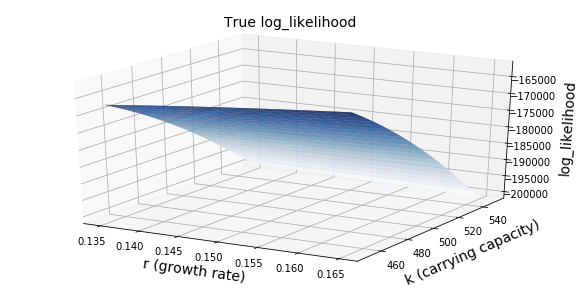

In [15]:
if n_parameters == 2:
    # generate data for surfaces
    test_splits = 20 # number of splits along each axis
    r_grid, k_grid, test_data = emutils.generate_grid(bounds.lower(), 
                                                      bounds.upper(), 
                                                      test_splits)    

    emu_grid = emutils.predict_grid(emu, test_data)
    real_grid = emutils.predict_grid(real_log_likelihood, test_data)

    plt.figure(figsize = (10, 5))
    ax = emuplt.surface(r_grid, k_grid, emu_grid, 
                        title = "True log_likelihood",
                        alpha = 0.8,
                        cmap="Blues",
                        x_label = "r (growth rate)",
                        y_label = "k (carrying capacity)"
                       )

    ax.plot_surface(r_grid, k_grid, real_grid, cmap="Reds", alpha = .5)

In [16]:
if n_parameters >= 3:
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        n_splits = axis_n_splits,
        shape = (n_parameters, n_parameters - 1),
        countour = False,
        additional_log_likelihoods = [real_log_likelihood]
    )

    plt.show(fig)

In [17]:
np.mean(np.abs(np.apply_along_axis(emu, 1, input_parameters).flatten() - target_likelihoods))

0.11486904366780072

In [32]:
# scoring function for CMA-ES and comparison
score = pints.SumOfSquaresError(problem)

# Timing single prediction

In [18]:
%%timeit
emu(real_parameters)

1.1 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%%timeit
real_log_likelihood(real_parameters)

33 µs ± 597 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Running and Timing MCMC

In [20]:
# for Logistic and Lotka-Voltera use default
# mcmc_method = None
# mcmc_method = pints.PopulationMCMC
mcmc_method = pints.AdaptiveCovarianceMCMC
# mcmc_method = pints.DifferentialEvolutionMCMC

# MCMC parameters
num_chains = 3
max_iters = 20000

In [21]:
emu_posterior = pints.LogPosterior(emu, log_prior)
real_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [22]:
# possible parameter starting points
# use three chains
# substitute for CMA-ES

xs = [
    real_parameters * 0.95,
    real_parameters * 0.90,
    real_parameters * 1.05,
]

In [23]:
# CMA-ES


In [24]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior, 
                              num_chains, 
                              xs, 
                              method = mcmc_method, 
                             )
emu_mcmc.set_max_iterations(max_iters)
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 52.4 s, sys: 560 ms, total: 52.9 s
Wall time: 54.2 s


In [25]:
%%time
# population MCMC
real_mcmc = pints.MCMCSampling(real_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                              )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 13 s, sys: 214 ms, total: 13.2 s
Wall time: 13.8 s


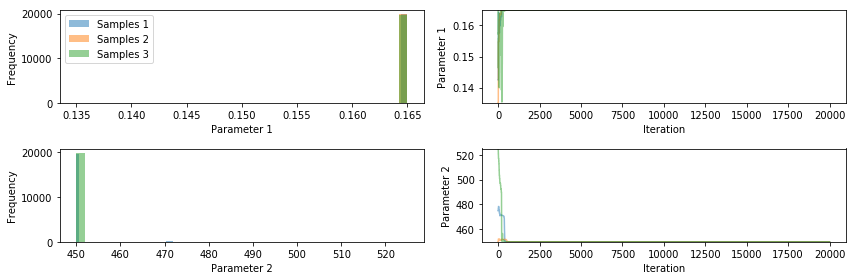

In [26]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

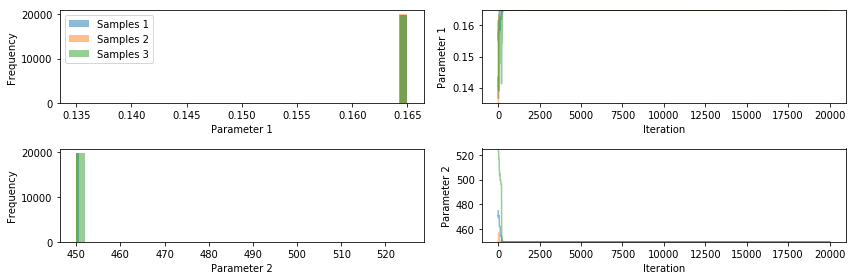

In [27]:
pints.plot.trace(real_chains)
plt.show()

In [28]:
# Look at likelihood changes along one chain
chain = emu_chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
real_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

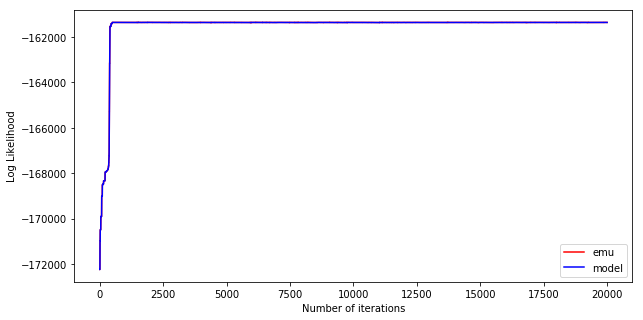

In [29]:
iters = range(len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color="Red", label='emu')
plt.plot(iters, real_prediction, color="Blue", label='model')
plt.legend()
plt.show()

In [30]:
diffs = np.abs(real_prediction - emu_prediction)

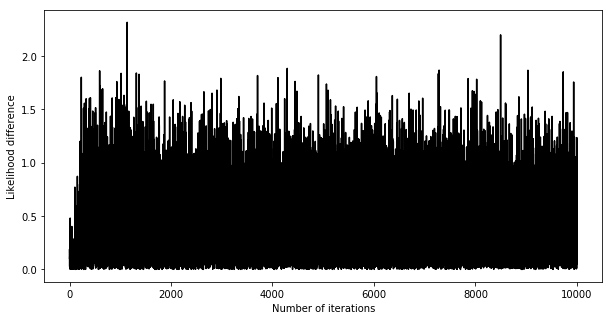

In [31]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood difference")
plt.plot(iters, diffs, color = "Black")
plt.show()